<a href="https://colab.research.google.com/github/HadenMoore/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    ## Install packages in Colab
    !pip install --upgrade category_encoders eli5 pandas-profiling plotly

In [0]:
# Import required packages
import category_encoders as ce
import eli5
import pandas as pd
import sklearn

# Check package versions
from distutils.version import StrictVersion
assert StrictVersion(ce.__version__) >= StrictVersion('2.0.0')
assert StrictVersion(eli5.__version__) >= StrictVersion('0.9.0')
assert StrictVersion(pd.__version__) >= StrictVersion('0.24.2')
assert StrictVersion(sklearn.__version__) >= StrictVersion('0.21.3')

# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn or xgboost cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree, Random Forest, or Gradient Boosting** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get and plot your model's **feature importances.**

**8.** Get and display your model's **permutation importances.**

**9.** Get your model's **test accuracy.** (One time, at the end.)

### Stretch Goals
- Make 2+ visualizations to explore relationships between features and target.
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Use permutation importances for feature selection.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [0]:
# Getting the mean for shot_made_flag
df['shot_made_flag'].mean()

0.4729187562688064

In [0]:
# Taking a Deeper look into the shots flag and the shot type to see if anything needs to be adjusted for layups or foul shots. 
df[['shot_made_flag', 'shot_type']].head()

,shot_made_flag,shot_type
0,0,3PT Field Goal
1,1,2PT Field Goal
2,0,2PT Field Goal
3,0,2PT Field Goal
4,0,2PT Field Goal


In [0]:
df['shot_made_flag'].describe()

count    13958.000000
mean         0.472919
std          0.499284
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: shot_made_flag, dtype: float64

In [0]:
df.mean()

game_id                    2.442837e+07
game_event_id              2.704385e+02
period                     2.412380e+00
minutes_remaining          4.727540e+00
seconds_remaining          2.850638e+01
shot_distance              1.760037e+01
loc_x                     -5.541625e-01
loc_y                      1.312580e+02
shot_made_flag             4.729188e-01
scoremargin_before_shot    1.615561e+00
dtype: float64

In [0]:
# Shots Missed are represented as 0 
# Shots Made are represented as 1 
y_train = df['shot_made_flag']
y_train.value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
# Majority Class Baseline for All Predictions
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(len(y_pred))

13958


In [0]:
# Using Classification for Baseline Accuracy using Majority Class for Every Prediction
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5270812437311936

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [62]:
# Splitting with datatime pandas function 
df = df.set_index('game_date')
train = df[:'2018-06'].reset_index()
test = df['2018-10':].reset_index()
df = df.reset_index()
train.shape, test.shape

((12180, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
# shot_made_flag is the Target
target = 'shot_made_flag'

# Getting dataframe with all train columns except the targe
train_features = train.drop(columns=[target])

# Get list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()


# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['game_id', 'game_event_id', 'period', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'loc_x', 'loc_y', 'scoremargin_before_shot', 'player_name', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type']


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn or xgboost cross-validation method.

In [0]:
from sklearn.model_selection import train_test_split

X_train = df
y_train = df['shot_made_flag']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42
) 

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11166, 20), (2792, 20), (11166,), (2792,))

In [0]:
# Stratified sampling gives you the same proportions of classes in train & test
y_train.value_counts(normalize=True)

0    0.527046
1    0.472954
Name: shot_made_flag, dtype: float64

In [0]:
y_val.value_counts(normalize=True)

0    0.527221
1    0.472779
Name: shot_made_flag, dtype: float64

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree, Random Forest, or Gradient Boosting model.

In [63]:
# Random Forest Classifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
# Fit on Train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


## 7. Get and plot your model's feature importances.

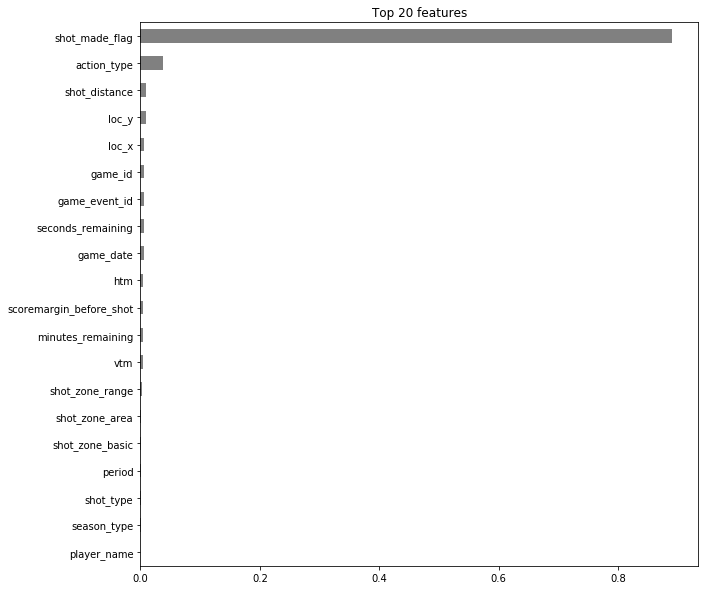

In [0]:
# Get Feature Importances 
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot Feature Importances 
%matplotlib inline
import matplotlib.pyplot as plt

n = 20 
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

## 8. Get and display your model's permutation importances.

In [0]:
feature = 'shot_distance'
X_val[feature].head()

2334    18
4907    21
9575    26
1584     5
9227     1
Name: shot_distance, dtype: int64

In [0]:
X_val[feature].value_counts()

25    357
26    293
24    237
1     219
2     158
23    138
27    136
22    101
19     97
0      88
18     77
21     69
17     68
20     67
16     66
3      61
28     59
15     54
4      51
12     34
8      33
10     31
13     31
5      31
29     30
7      30
14     28
11     27
6      26
9      25
30     19
31     15
33     10
32      5
55      2
47      2
34      2
38      1
39      1
41      1
40      1
49      1
53      1
66      1
68      1
70      1
78      1
37      1
67      1
35      1
59      1
71      1
Name: shot_distance, dtype: int64

In [0]:
import numpy as np
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
X_val_permuted[feature].head()

2334    22
4907    26
9575    24
1584    24
9227    20
Name: shot_distance, dtype: int64

In [0]:
X_val_permuted['scoremargin_before_shot'].value_counts()

 0.0     205
-2.0     141
-1.0     130
-3.0     113
 1.0     110
 4.0     107
-5.0     106
 2.0     104
-4.0     102
 3.0     100
 7.0      92
 5.0      83
 6.0      80
 10.0     78
 9.0      73
 8.0      72
-6.0      67
-9.0      63
 12.0     60
-7.0      60
 11.0     59
-8.0      57
 13.0     47
-11.0     46
-10.0     44
 15.0     41
 14.0     40
 18.0     38
-13.0     37
-14.0     36
        ... 
-22.0      9
 22.0      8
-20.0      8
 23.0      8
-19.0      7
 28.0      7
-21.0      6
-24.0      6
-23.0      6
-26.0      5
 26.0      5
 29.0      5
 33.0      5
 27.0      4
 30.0      4
 32.0      3
 40.0      2
 36.0      2
-27.0      2
-28.0      1
 39.0      1
 42.0      1
 34.0      1
 37.0      1
 31.0      1
 38.0      1
-29.0      1
-31.0      1
-30.0      1
-39.0      1
Name: scoremargin_before_shot, Length: 73, dtype: int64

In [0]:
column  = 'scoremargin_before_shot'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without scoremargin_before_shot: 1.0
Validation Accuracy with scoremargin_before_shot: 1.0
Drop-Column Importance for scoremargin_before_shot: 0.0


In [0]:
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with htm: 1.0
Validation Accuracy with htm permuted: 1.0
Permutation Importance: 0.0


In [0]:
feature = 'minutes_remaining'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with minutes_remaining: 1.0
Validation Accuracy with minutes_remaining permuted: 1.0
Permutation Importance: 0.0


## 9. Get your model's test accuracy

> (One time, at the end.)

In [64]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    XGBRegressor(objective='reg:squarederror', random_state=42)
)

# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
param_distributions = {
    'xgbregressor__n_estimators': randint(100, 1000), 
    'xgbregressor__max_depth': randint(3, 10), 
    'xgbregressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.8s finished


In [0]:
pipeline = search.best_estimator_

In [71]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 8, 'xgbregressor__n_estimators': 143}
Cross-validation MAE 1.1162493746916539e-05


In [74]:
pipeline.score(X_test, y_test)

ValueError: ignored